In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [2]:
# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [3]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    
    # Converts a PIL.Image or numpy.ndarray to
    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    transform=torchvision.transforms.ToTensor(),    
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


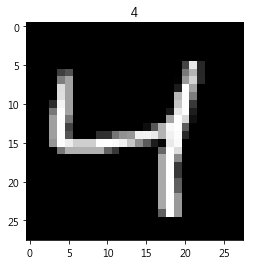

In [4]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [5]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (64, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

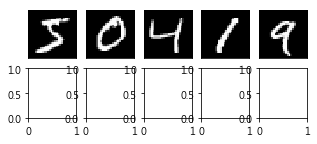

In [8]:
# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

In [9]:
for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
#             _, decoded_data = autoencoder(view_data)
#             for i in range(N_TEST_IMG):
#                 a[1][i].clear()
#                 a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
#                 a[1][i].set_xticks(()); a[1][i].set_yticks(())
#             plt.draw(); plt.pause(0.05)

Epoch:  0 | train loss: 0.2306
Epoch:  0 | train loss: 0.0709
Epoch:  0 | train loss: 0.0703
Epoch:  0 | train loss: 0.0643
Epoch:  0 | train loss: 0.0594
Epoch:  0 | train loss: 0.0576
Epoch:  0 | train loss: 0.0548
Epoch:  0 | train loss: 0.0498
Epoch:  0 | train loss: 0.0545
Epoch:  0 | train loss: 0.0460
Epoch:  1 | train loss: 0.0500
Epoch:  1 | train loss: 0.0486
Epoch:  1 | train loss: 0.0473
Epoch:  1 | train loss: 0.0444
Epoch:  1 | train loss: 0.0469
Epoch:  1 | train loss: 0.0475
Epoch:  1 | train loss: 0.0471
Epoch:  1 | train loss: 0.0488
Epoch:  1 | train loss: 0.0458
Epoch:  1 | train loss: 0.0452
Epoch:  2 | train loss: 0.0424
Epoch:  2 | train loss: 0.0443
Epoch:  2 | train loss: 0.0427
Epoch:  2 | train loss: 0.0385
Epoch:  2 | train loss: 0.0423
Epoch:  2 | train loss: 0.0417
Epoch:  2 | train loss: 0.0397
Epoch:  2 | train loss: 0.0396
Epoch:  2 | train loss: 0.0412
Epoch:  2 | train loss: 0.0448
Epoch:  3 | train loss: 0.0438
Epoch:  3 | train loss: 0.0394
Epoch:  

In [10]:
# plt.ioff()
# plt.show()

# # visualize in 3D plot
# view_data = train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.
# encoded_data, _ = autoencoder(view_data)
# fig = plt.figure(2); ax = Axes3D(fig)
# X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
# values = train_data.train_labels[:200].numpy()
# for x, y, z, s in zip(X, Y, Z, values):
#     c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
# ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
# plt.show()